In [1]:
import matplotlib.pyplot as plt
import numpy as np

import random
from itertools import cycle, accumulate
import librosa

import warnings
warnings.filterwarnings("ignore")

from composition.common import (
    sinusoid, sweeping_sinusoid, line_segment, constant, triangle, square, adsr,
    autotune, SECOND, get_t, autotune_explicit, phasor,
    sweeping_square, sweeping_triangle, bpc, rescale
)
from composition.instrument import Score, Part, Phrase

plt.rcParams['figure.figsize'] = (15, 5)

In [2]:
def scale_from_intervals(intervals):
    steps = cycle(intervals)
    scale = [0]

    while scale[-1] < 120:
        scale.append(scale[-1] + next(steps))
    
    return np.array(scale, dtype='int')

In [3]:
def harmonics_to_cents(harmonics):
    ratios = [b / a for a, b in zip(harmonics[:-1], harmonics[1:])]
    cents = [np.log2(x)*12 for x in ratios]
    
    return cents

In [4]:
def random_adsr(duration):
    break_points = sorted(np.random.uniform(0, duration, 3))
    durs = np.diff(np.array([0, *break_points, duration]))
    env = adsr(*durs, 1, 0.5)
    print(sum(durs))
    return env

In [5]:
def harmonics_to_pitches(base_pitch, harmonics):
    pitches = harmonics_to_cents(harmonics)
    pitches = accumulate(pitches, initial=0)
    pitches = [base_pitch + p for p in pitches]
    
    return pitches

* violin: mean: -43.36, std: 5.23
* viola: mean: -42.76, std: 7.77
* cello: mean: -57.26, std: 6.12
* flute: mean: -55.27, std: 8.37
* flute2: mean: -55.27, std: 8.37

- Violin 55-103
- Viola 48-91
- Cello 36-76
- Flute 60-96
- Flute2 55-91

In [6]:
higher_harms = harmonics_to_pitches(36, [2, 11, 13, 15, 17, 19, 21, 23, 25, 27])[1:]

In [7]:
stretched_higher_harms = harmonics_to_pitches(36, [n ** 1.02 for n in [2, 11, 13, 15, 17, 19, 21, 23, 25, 27]])[1:]

In [8]:
duration = 25
pitches = sweeping_sinusoid(duration, 0.1, 0.01, 72, 3)
pitches += line_segment(duration, 0, 7)
pitches = autotune(pitches, 0.9)
pitches += sinusoid(duration, 4, 0, 0.15)

amps = np.concatenate([adsr(0.1, 0.1, 1 - (0.1 + 0.1 + 0.5), 0.5, 1, 0.8) for _ in range(25)])
padding = len(pitches) - len(amps)
amps = np.pad(amps, (0, padding), mode='edge')

# amps = sweeping_triangle(duration, 2, 6, 0.1)

amps = rescale(amps, -70, -55)
amps += line_segment(duration, 0, 8)
amps += sinusoid(duration, 4, 0, 1, phase=0.1324)

In [9]:
vln1_phrase = Phrase(pitches, amps)
vln1_part = Part('Vln. 1', 'violin')
vln1_part.add_phrase(vln1_phrase)

In [11]:
vln1_part.play()

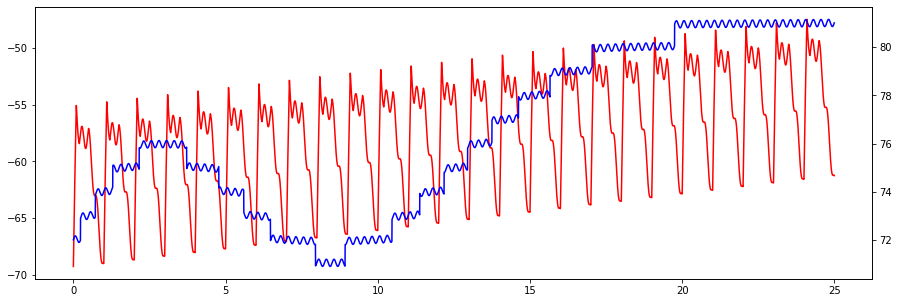

In [12]:
vln1_part.show()

In [30]:
duration = 25
pitches = sweeping_sinusoid(duration, 0.1, 2, 60, 3)

amps = sweeping_triangle(duration, 1, 8, 0.5, -80, -12)

flute_ph = Phrase(pitches, amps)
flute_part = Part('Flt. 1', 'flute')
flute_part.add_phrase(flute_ph)

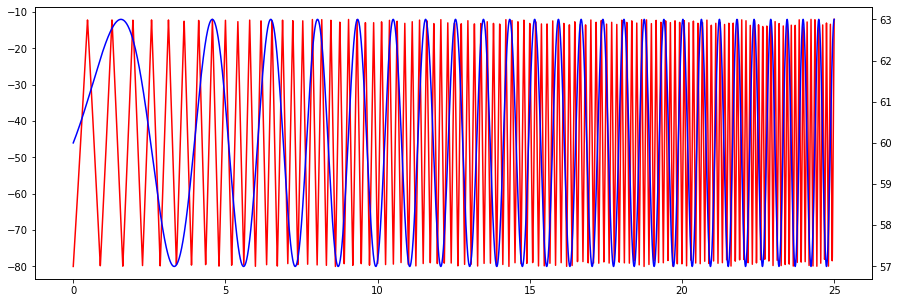

In [31]:
flute_part.show()

In [32]:
flute_part.play()

In [15]:
duration = 25
pitches = sweeping_sinusoid(duration, 0.1, 2, 72, 3)
pitches += line_segment(duration, 0, 7)
pitches = autotune(pitches, 0.9)
pitches += sinusoid(duration, 4, 0, 0.15)

amps = np.concatenate([adsr(0.1, 0.1, 1 - (0.1 + 0.1 + 0.5), 0.5, 1, 0.8) for _ in range(25)])
padding = len(pitches) - len(amps)
amps = np.pad(amps, (0, padding), mode='edge')

# amps = sweeping_triangle(duration, 2, 6, 0.1)

amps = rescale(amps, -70, -55)
amps += line_segment(duration, 0, 8)
amps += sinusoid(duration, 4, 0, 1, phase=0.1324)

In [16]:
import pickle

In [17]:
with open('audio-data/original/22 Seconds V/score.pkl', 'rb') as f:
    score = pickle.load(f)

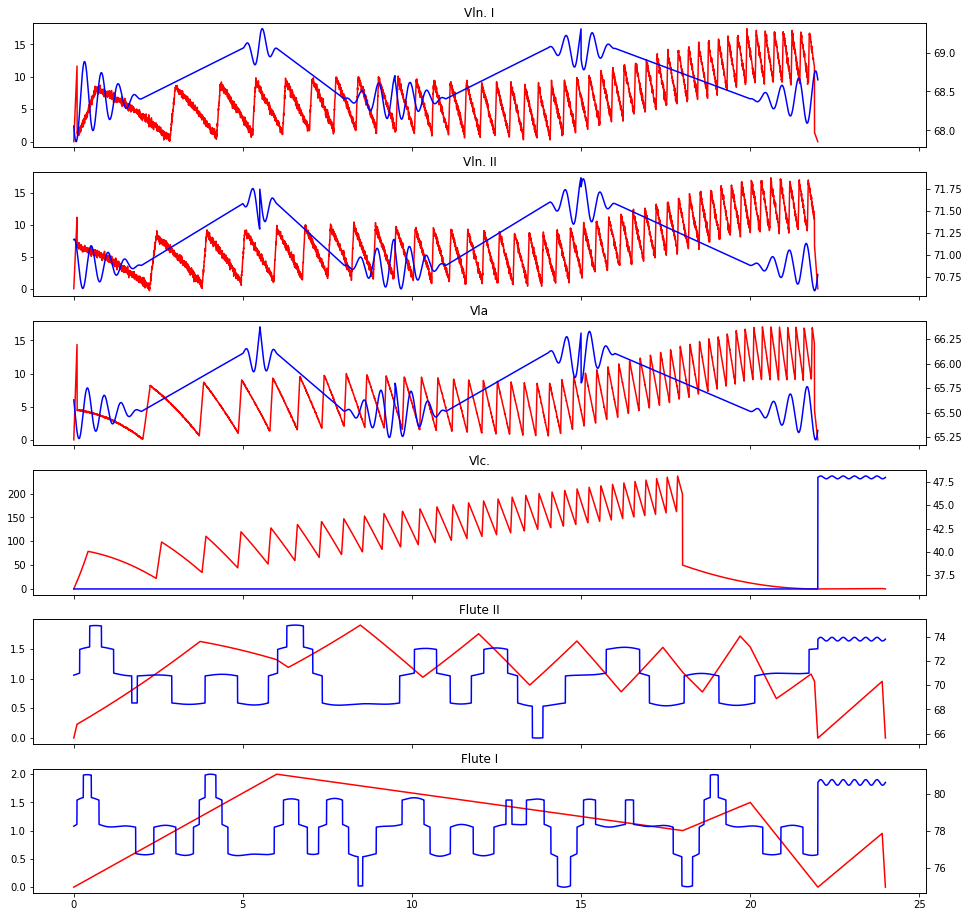

In [18]:
score.show()

In [19]:
for part in score.parts:
    print(part.instrument) 

violin
violin
viola
cello
flute2
flute


In [20]:
cello = score.parts[3]
flute2 = score.parts[4]
flute1 = score.parts[5]

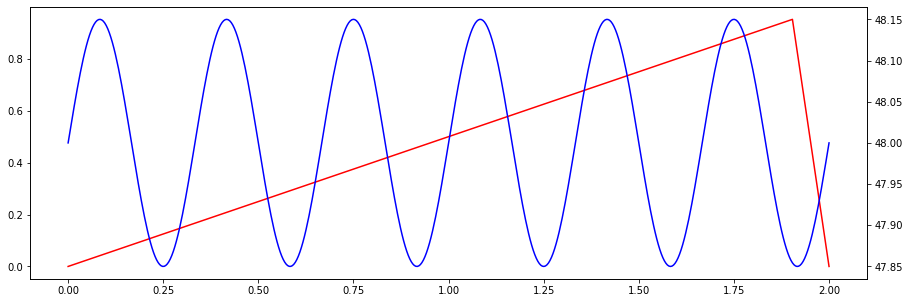

In [21]:
cello.phrases[1].show()

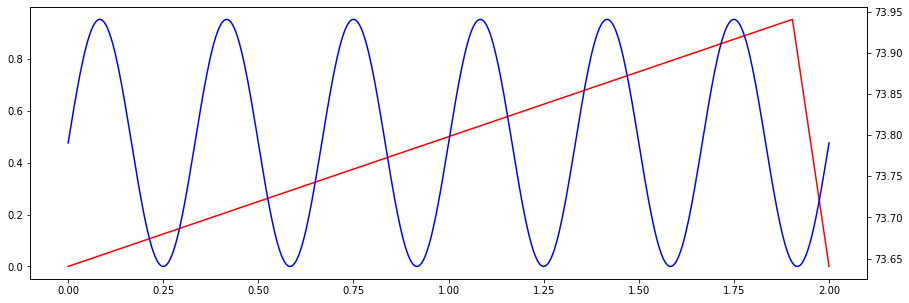

In [22]:
flute2.phrases[1].show()

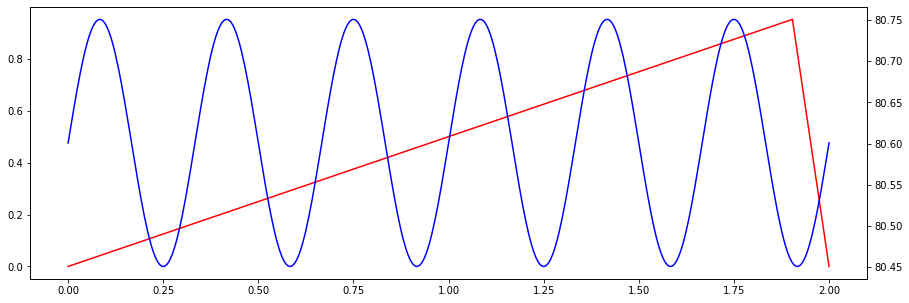

In [23]:
flute1.phrases[1].show()

In [24]:
cello.phrases[1].pitch[:] = 61.

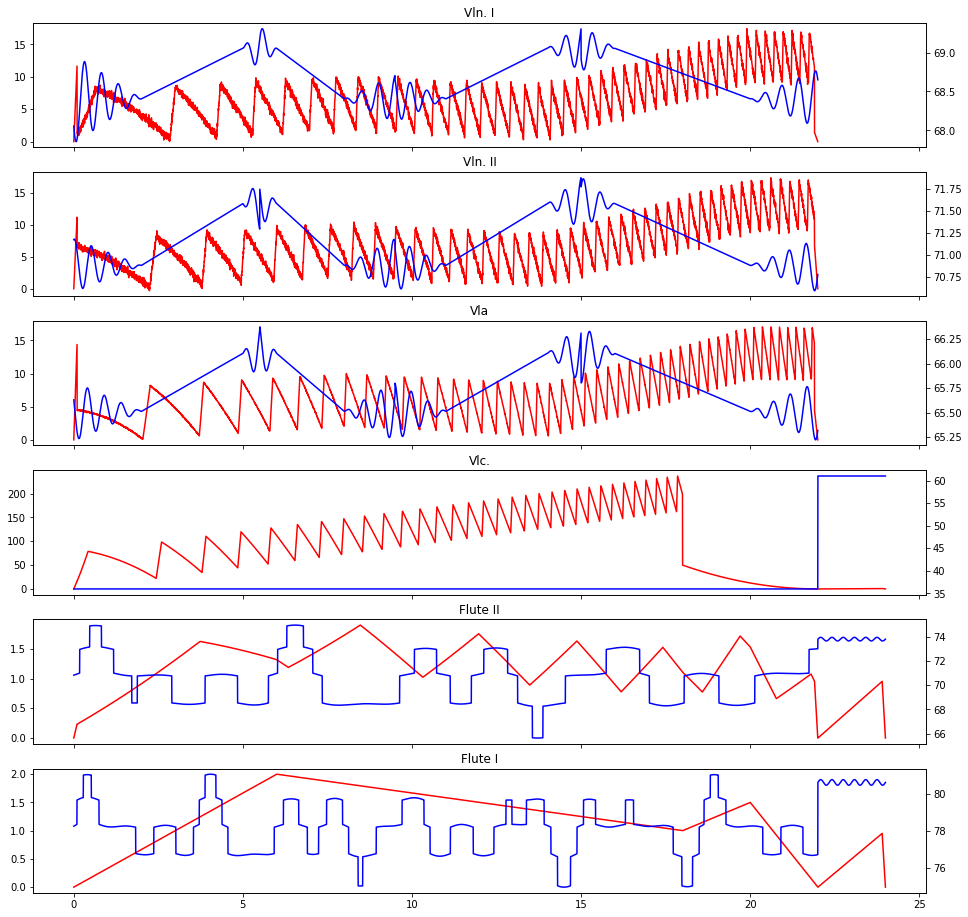

In [25]:
score.show()

In [26]:
def remap(xs, out_min, out_max):
    result = (xs - xs.min()) / xs.max()
    result = result * (out_max - out_min) + out_min
    
    return result

In [27]:
with open('audio-data/original/22 Seconds V/score.pkl', 'rb') as f:
    score = pickle.load(f)

In [28]:
score.parts[0].phrases[0].loudness = remap(score.parts[0].phrases[0].loudness, -70, -33)

In [29]:
score.parts[1].phrases[0].loudness = remap(score.parts[1].phrases[0].loudness, -70, -33)

In [30]:
score.parts[2].phrases[0].loudness = remap(score.parts[2].phrases[0].loudness, -70, -33)
score.parts[2].phrases[0].loudness += np.random.randn(len(score.parts[2].phrases[0].loudness))*0.5
score.parts[2].instrument = 'violin'

In [31]:
score.parts[3].phrases[0].loudness = sweeping_triangle(22, 0.25, 4, 0.1, -43, -33) - 25
score.parts[3].phrases[0].loudness += sweeping_square(22, 0.125, 2, 0.5, -1, 0)
score.parts[3].phrases[0].loudness += line_segment(22, 0, 6)
score.parts[3].phrases[0].loudness += np.random.randn(len(score.parts[3].phrases[0].loudness))*0.5

score.parts[3].phrases[1].loudness = remap(score.parts[3].phrases[1].loudness, -69, -52)
score.parts[3].instrument = 'cello'

In [32]:
score.parts[4].phrases[0].loudness = remap(score.parts[5].phrases[0].loudness, -63, 6-47)
score.parts[4].phrases[1].loudness = remap(score.parts[5].phrases[1].loudness, -60, -60)

In [33]:
score.parts[4].play()